In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import mlflow
from sklearn.preprocessing import StandardScaler

In [7]:
features_df = pd.read_csv('../data/processed/features.csv')

In [8]:
from sklearn.preprocessing import LabelEncoder
X = features_df.drop('label', axis=1).values 

Number of clusters: 2, Silhouette Score: 0.3967
Number of clusters: 3, Silhouette Score: 0.1902
Number of clusters: 4, Silhouette Score: 0.2065
Number of clusters: 5, Silhouette Score: 0.2101
Number of clusters: 6, Silhouette Score: 0.1641
Number of clusters: 7, Silhouette Score: 0.1654
Number of clusters: 8, Silhouette Score: 0.1691
Number of clusters: 9, Silhouette Score: 0.1688
Number of clusters: 10, Silhouette Score: 0.1708


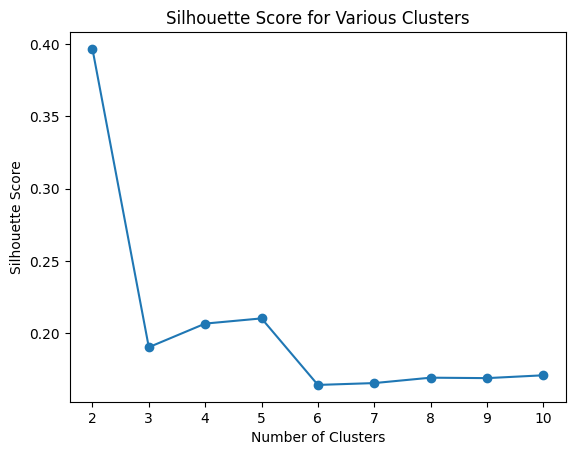

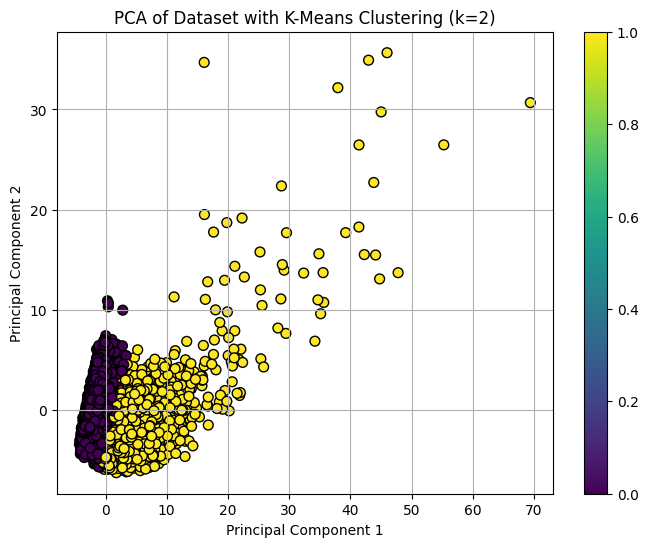

In [9]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


num_clusters = range(2, 11)

silhouette_scores = []


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("KMeans_Clustering")

with mlflow.start_run(run_name="K-Means Clustering"):
    for k in num_clusters:
        
        with mlflow.start_run(run_name=f"K-Means with k={k}", nested=True):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_scaled)
            
            # Assign clusters to the dataset
            labels = kmeans.labels_
            
            # Calculate silhouette score and append to list
            silhouette_avg = silhouette_score(X_scaled, labels)
            silhouette_scores.append(silhouette_avg)
            
            # Log parameters, metrics, and model
            mlflow.log_param("num_clusters", k)
            mlflow.log_metric("silhouette_score", silhouette_avg)
            
            print(f"Number of clusters: {k}, Silhouette Score: {silhouette_avg:.4f}")
    
    # Log silhouette scores for all tested cluster numbers
    fig, ax = plt.subplots()
    ax.plot(num_clusters, silhouette_scores, marker='o')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Score')
    plt.title('Silhouette Score for Various Clusters')
    mlflow.log_figure(fig, "silhouette_scores.png")

    # Perform PCA for visualization (2D)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Cluster using optimal number of clusters found from silhouette score
    optimal_k = num_clusters[silhouette_scores.index(max(silhouette_scores))]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(f'PCA of Dataset with K-Means Clustering (k={optimal_k})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.grid(True)
    plt.show()

    # Log the optimal model
    mlflow.sklearn.log_model(kmeans, "optimal_model")
